# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# Read the dataset
cleaned_df = pd.read_csv('/Users/priyakundu/Documents/NYU Capstone WaterVue Files/Data Processing/Updated_Dataframe_WaterQual.csv')
cleaned_df

Location Sample Date  Chlorophyll A  \
0          #1 HILLSBORO CANAL US 1  2006-02-28      12.100000   
1          #1 HILLSBORO CANAL US 1  2006-08-31       4.430000   
2          #1 HILLSBORO CANAL US 1  2007-02-28       2.605000   
3          #1 HILLSBORO CANAL US 1  2007-08-31       4.890000   
4          #1 HILLSBORO CANAL US 1  2008-02-29       5.925000   
..                             ...         ...            ...   
853  #89 NOB HILL RD POMPANO CANAL  2020-02-29       3.933333   
854  #89 NOB HILL RD POMPANO CANAL  2020-08-31       1.570000   
855  #89 NOB HILL RD POMPANO CANAL  2021-02-28       2.966667   
856  #89 NOB HILL RD POMPANO CANAL  2021-08-31       5.510000   
857  #89 NOB HILL RD POMPANO CANAL  2022-02-28       2.900000   

     Dissolved Oxygen   Salinity  Specific Conductance  Total Nitrogen  \
0            6.980000  19.400000             10.351373        0.830000   
1            5.540000  15.750000             10.165844        0.981000   
2            6.195000  23.200000             10.501905        0.754000   
3            4.730000  31.100000             10.774781        0.777000   
4            5.770000  12.500000              9.893361        1.440000   
..                ...        ...                   ...             ...   
853          5.703333   0.310000              6.451930        1.097133   
854          7.760000   0.250000              6.265301        0.910000   
855          5.833333   0.233333              6.153383        0.984033   
856          5.370000   0.270000              6.324359        1.410500   
857          4.940000   0.290000              6.388561        1.040000   

     Total Phosphorus  Turbidity  
0            0.086000   2.400000  
1            0.109000   1.400000  
2            0.083500   1.650000  
3            0.094000   2.300000  
4            0.102000   2.050000  
..                ...        ...  
853          0.014000   0.750000  
854          0.011000   0.000000  
855          0.003667   0.566667  
856          0.049000   0.775000  
857          0.008000   0.550000  

[858 rows x 9 columns]

## Splitting

In [3]:
sorted_df = cleaned_df.sort_values(by='Sample Date', ascending=True)

In [4]:
# Split data into train and test sets
train_data = sorted_df.iloc[:-3*cleaned_df["Location"].nunique()].sort_values(by=['Location', 'Sample Date'], ascending=True)  # Use all but the last 12 months for training
test_data = sorted_df.iloc[-3*cleaned_df["Location"].nunique():].sort_values(by=['Location', 'Sample Date'], ascending=True)   # Use the last 12 months for testing

# Forecasting

## Chlorophyll A

In [5]:
param = 'Chlorophyll A'

In [6]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location].set_index("Sample Date")
    train_df.index = pd.to_datetime(train_df.index)  # Convert index to DateTimeIndex
    
    # Fit ETS model
    trend = 'additive'  # or 'multiplicative'
    seasonal_periods = 2  # Assuming monthly data
    model = ExponentialSmoothing(train_df[param], trend=trend, seasonal='add', seasonal_periods=seasonal_periods)
    result = model.fit()
    
    # Forecast future values
    forecast = result.forecast(steps=3)  # Forecasting next 3 periods into the future
    forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast
    
    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index, param: forecast_values}))

pred_data = pd.concat(predictions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_30097/2626036118.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_30097/2626036118.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-

In [7]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

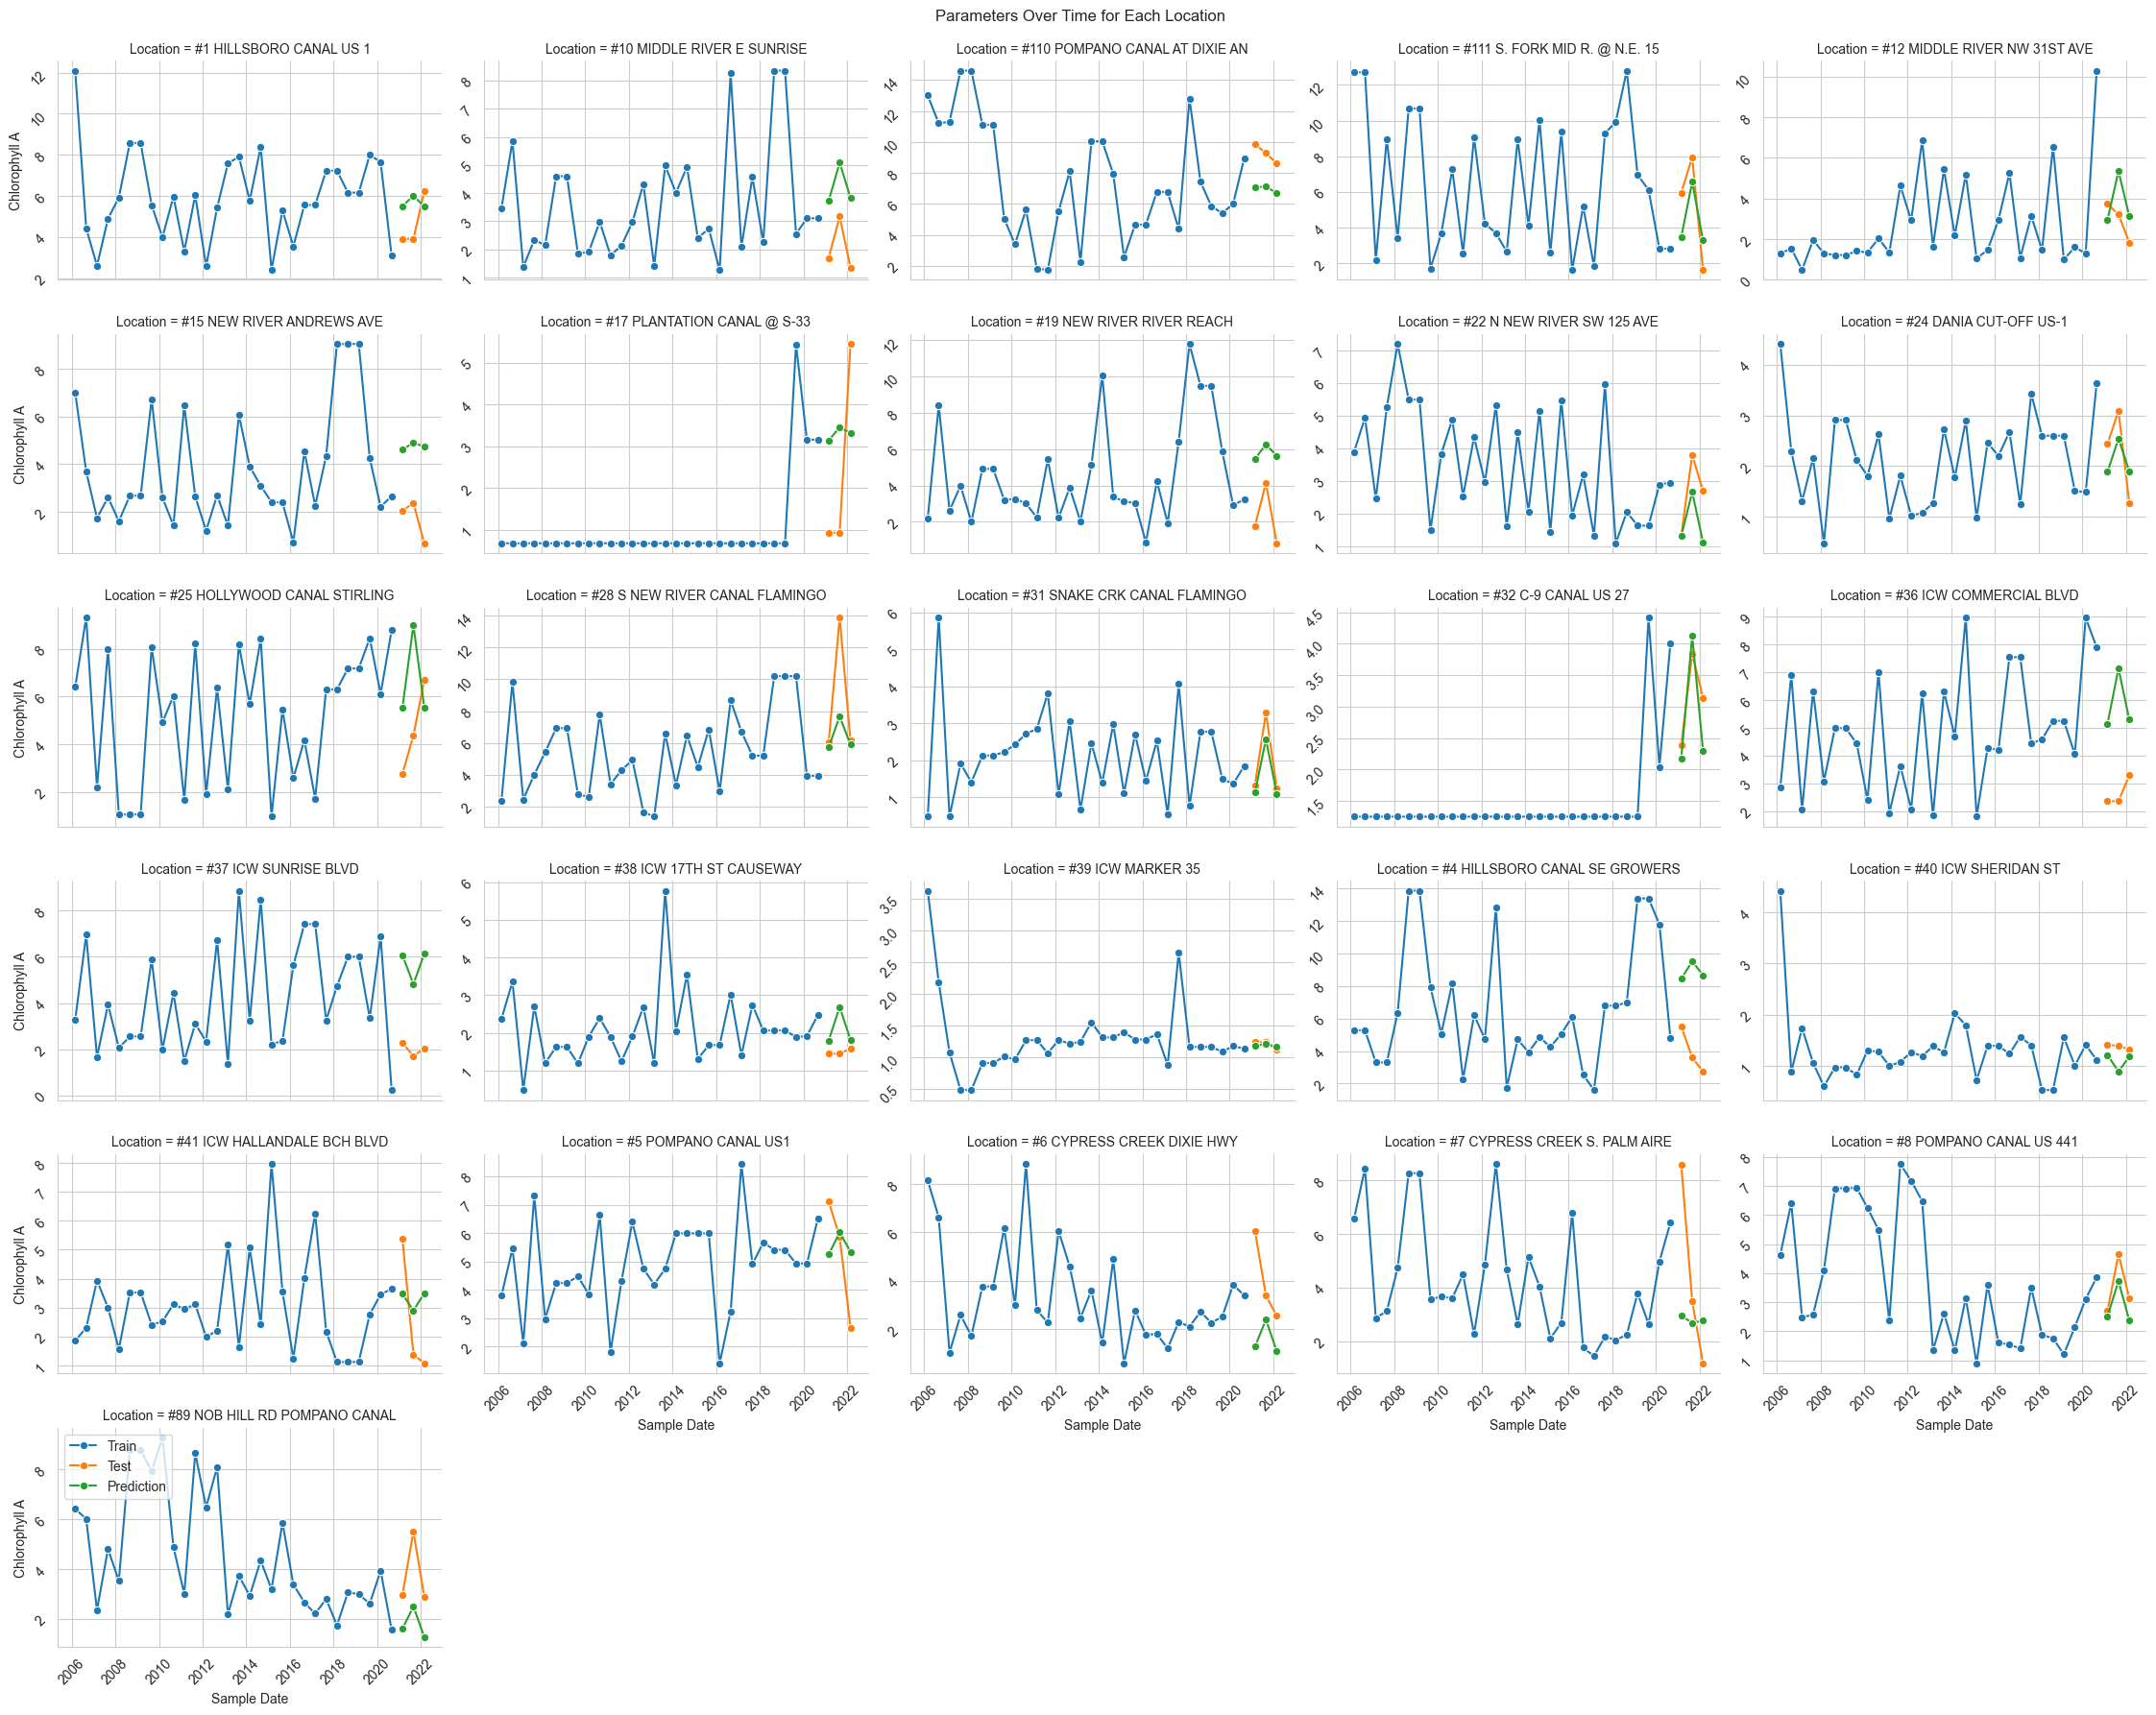

In [8]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Parameters Over Time for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [9]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [10]:
accuracy.sort_values(by="RMSE", ascending=False)

Location       MAE        MSE      RMSE
18   #4 HILLSBORO CANAL SE GROWERS  4.930419  26.307157  5.129050
7        #19 NEW RIVER RIVER REACH  3.542802  13.769749  3.710761
15            #37 ICW SUNRISE BLVD  3.670302  13.644160  3.693800
11  #28 S NEW RIVER CANAL FLAMINGO  2.254502  13.001934  3.605819
23   #7 CYPRESS CREEK S. PALM AIRE  2.682508  11.690517  3.419140
14         #36 ICW COMMERCIAL BLVD  3.191966  11.561052  3.400155
10    #25 HOLLYWOOD CANAL STIRLING  2.846834  10.134851  3.183528
5        #15 NEW RIVER ANDREWS AVE  3.050849   9.808373  3.131832
22      #6 CYPRESS CREEK DIXIE HWY  2.419285   8.688195  2.947574
2   #110 POMPANO CANAL AT DIXIE AN  2.285467   5.361686  2.315531
6      #17 PLANTATION CANAL @ S-33  2.289910   5.272548  2.296203
1       #10 MIDDLE RIVER E SUNRISE  2.143654   4.655241  2.157601
25   #89 NOB HILL RD POMPANO CANAL  1.998375   4.518245  2.125616
20     #41 ICW HALLANDALE BCH BLVD  1.945369   3.924343  1.980996
3    #111 S. FORK MID R. @ N.E. 15  1.840795   3.621014  1.902896
21            #5 POMPANO CANAL US1  1.569150   3.552253  1.884742
0          #1 HILLSBORO CANAL US 1  1.479777   2.514667  1.585770
4     #12 MIDDLE RIVER NW 31ST AVE  1.404040   2.283464  1.511113
8       #22 N NEW RIVER SW 125 AVE  0.909494   1.253050  1.119397
16        #38 ICW 17TH ST CAUSEWAY  0.606532   0.572028  0.756325
24         #8 POMPANO CANAL US 441  0.627443   0.496019  0.704286
9           #24 DANIA CUT-OFF US-1  0.575397   0.332409  0.576549
13             #32 C-9 CANAL US 27  0.448407   0.278959  0.528165
12    #31 SNAKE CRK CANAL FLAMINGO  0.360834   0.195376  0.442014
19             #40 ICW SHERIDAN ST  0.280503   0.102449  0.320077
17               #39 ICW MARKER 35  0.043708   0.002069  0.045491

## Dissolved Oxygen

In [11]:
param = 'Dissolved Oxygen'

In [12]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location].set_index("Sample Date")
    train_df.index = pd.to_datetime(train_df.index)  # Convert index to DateTimeIndex
    
    # Fit ETS model
    trend = 'additive'  # or 'multiplicative'
    seasonal_periods = 2  # Assuming monthly data
    model = ExponentialSmoothing(train_df[param], trend=trend, seasonal='add', seasonal_periods=seasonal_periods)
    result = model.fit()
    
    # Forecast future values
    forecast = result.forecast(steps=3)  # Forecasting next 3 periods into the future
    forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast
    
    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index, param: forecast_values}))

pred_data = pd.concat(predictions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_30097/2626036118.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_30097/2626036118.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-

In [13]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

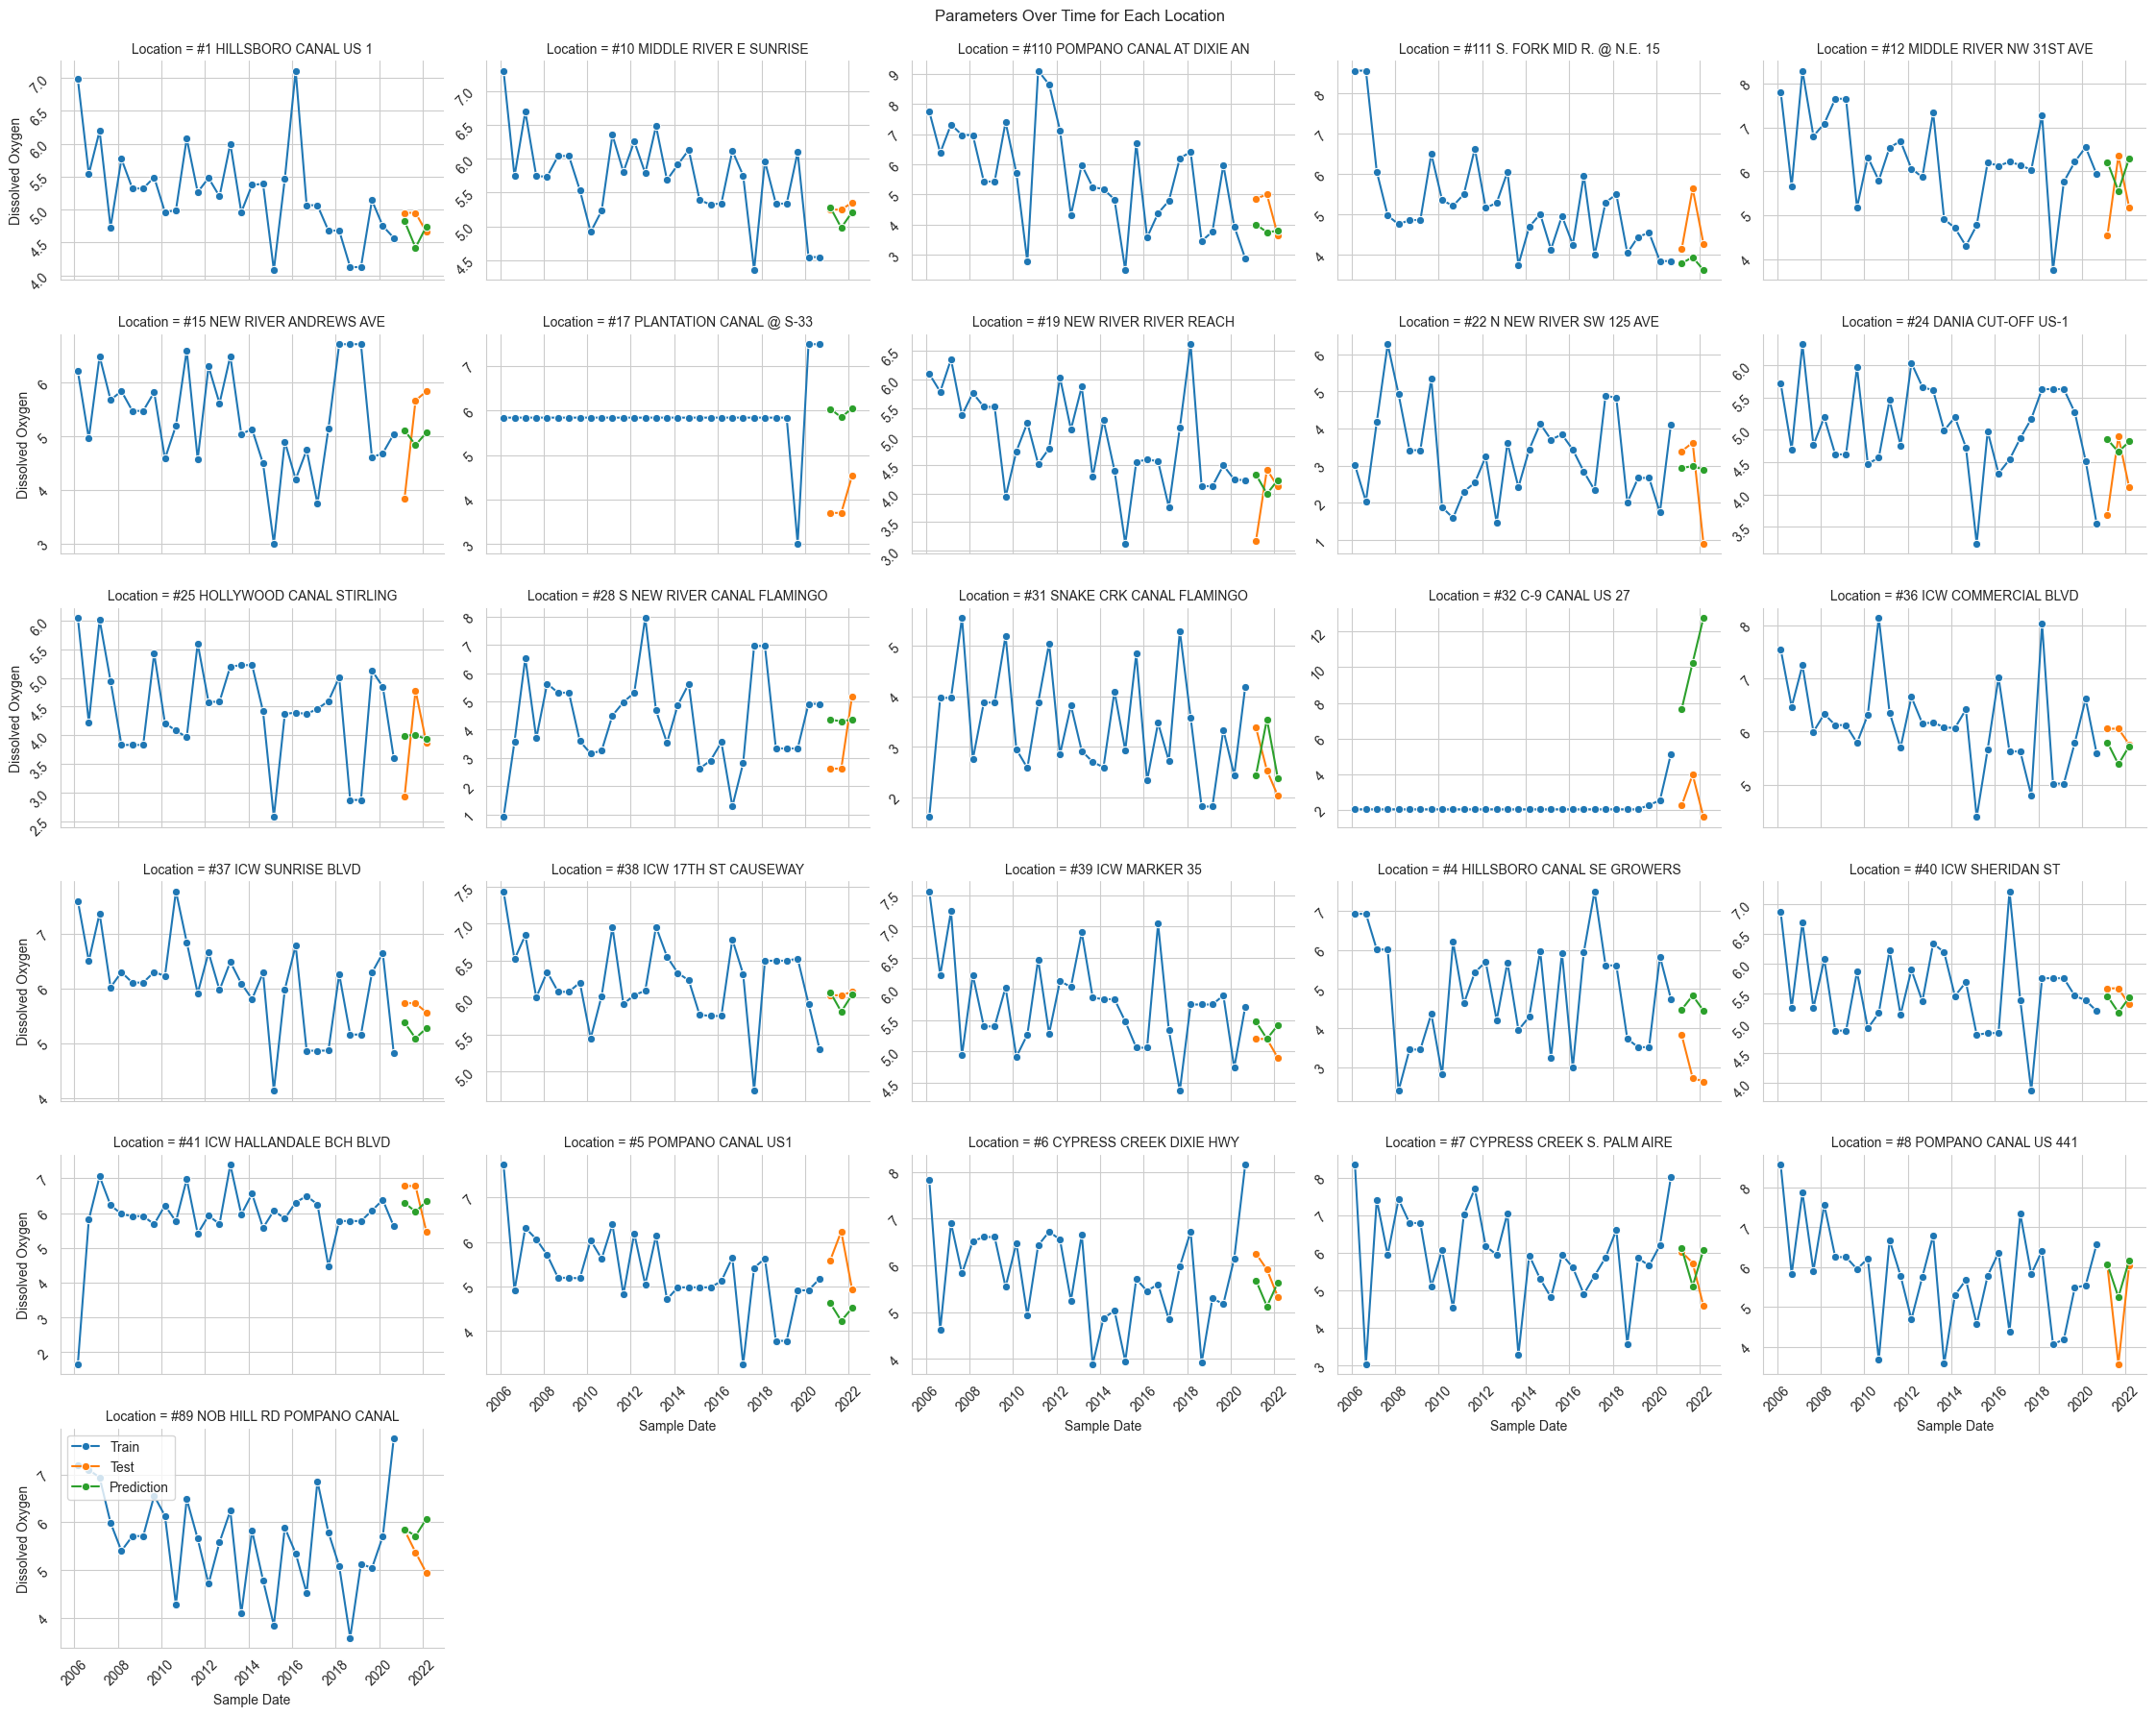

In [14]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Parameters Over Time for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [15]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [16]:
accuracy.sort_values(by="RMSE")

Location       MAE        MSE      RMSE
16        #38 ICW 17TH ST CAUSEWAY  0.101058   0.017571  0.132554
1       #10 MIDDLE RIVER E SUNRISE  0.148012   0.030918  0.175836
19             #40 ICW SHERIDAN ST  0.214760   0.063835  0.252657
0          #1 HILLSBORO CANAL US 1  0.246303   0.100950  0.317726
17               #39 ICW MARKER 35  0.264953   0.114864  0.338916
14         #36 ICW COMMERCIAL BLVD  0.320045   0.171195  0.413758
15            #37 ICW SUNRISE BLVD  0.428840   0.207372  0.455381
22      #6 CYPRESS CREEK DIXIE HWY  0.552161   0.345299  0.587621
25   #89 NOB HILL RD POMPANO CANAL  0.498471   0.465531  0.682298
20     #41 ICW HALLANDALE BCH BLVD  0.696324   0.510330  0.714374
7        #19 NEW RIVER RIVER REACH  0.566701   0.512613  0.715970
10    #25 HOLLYWOOD CANAL STIRLING  0.633807   0.580217  0.761720
9           #24 DANIA CUT-OFF US-1  0.703836   0.638341  0.798963
12    #31 SNAKE CRK CANAL FLAMINGO  0.768797   0.678112  0.823476
2   #110 POMPANO CANAL AT DIXIE AN  0.748308   0.769718  0.877336
23   #7 CYPRESS CREEK S. PALM AIRE  0.737432   0.879408  0.937767
24         #8 POMPANO CANAL US 441  0.614898   0.950422  0.974896
5        #15 NEW RIVER ANDREWS AVE  0.957381   0.966200  0.982955
3    #111 S. FORK MID R. @ N.E. 15  0.900865   1.143354  1.069277
8       #22 N NEW RIVER SW 125 AVE  1.026974   1.525865  1.235259
4     #12 MIDDLE RIVER NW 31ST AVE  1.194816   1.560763  1.249305
21            #5 POMPANO CANAL US1  1.136648   1.726235  1.313863
11  #28 S NEW RIVER CANAL FLAMINGO  1.409702   2.162537  1.470557
18   #4 HILLSBORO CANAL SE GROWERS  1.529428   2.736356  1.654194
6      #17 PLANTATION CANAL @ S-33  2.001558   4.128886  2.031966
13             #32 C-9 CANAL US 27  7.626984  64.634401  8.039552

## Salinity

In [17]:
param = 'Salinity'

In [18]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location].set_index("Sample Date")
    train_df.index = pd.to_datetime(train_df.index)  # Convert index to DateTimeIndex
    
    # Fit ETS model
    trend = 'additive'  # or 'multiplicative'
    seasonal_periods = 2  # Assuming monthly data
    model = ExponentialSmoothing(train_df[param], trend=trend, seasonal='add', seasonal_periods=seasonal_periods)
    result = model.fit()
    
    # Forecast future values
    forecast = result.forecast(steps=3)  # Forecasting next 3 periods into the future
    forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast
    
    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index, param: forecast_values}))

pred_data = pd.concat(predictions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_30097/2626036118.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_30097/2626036118.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-

In [19]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

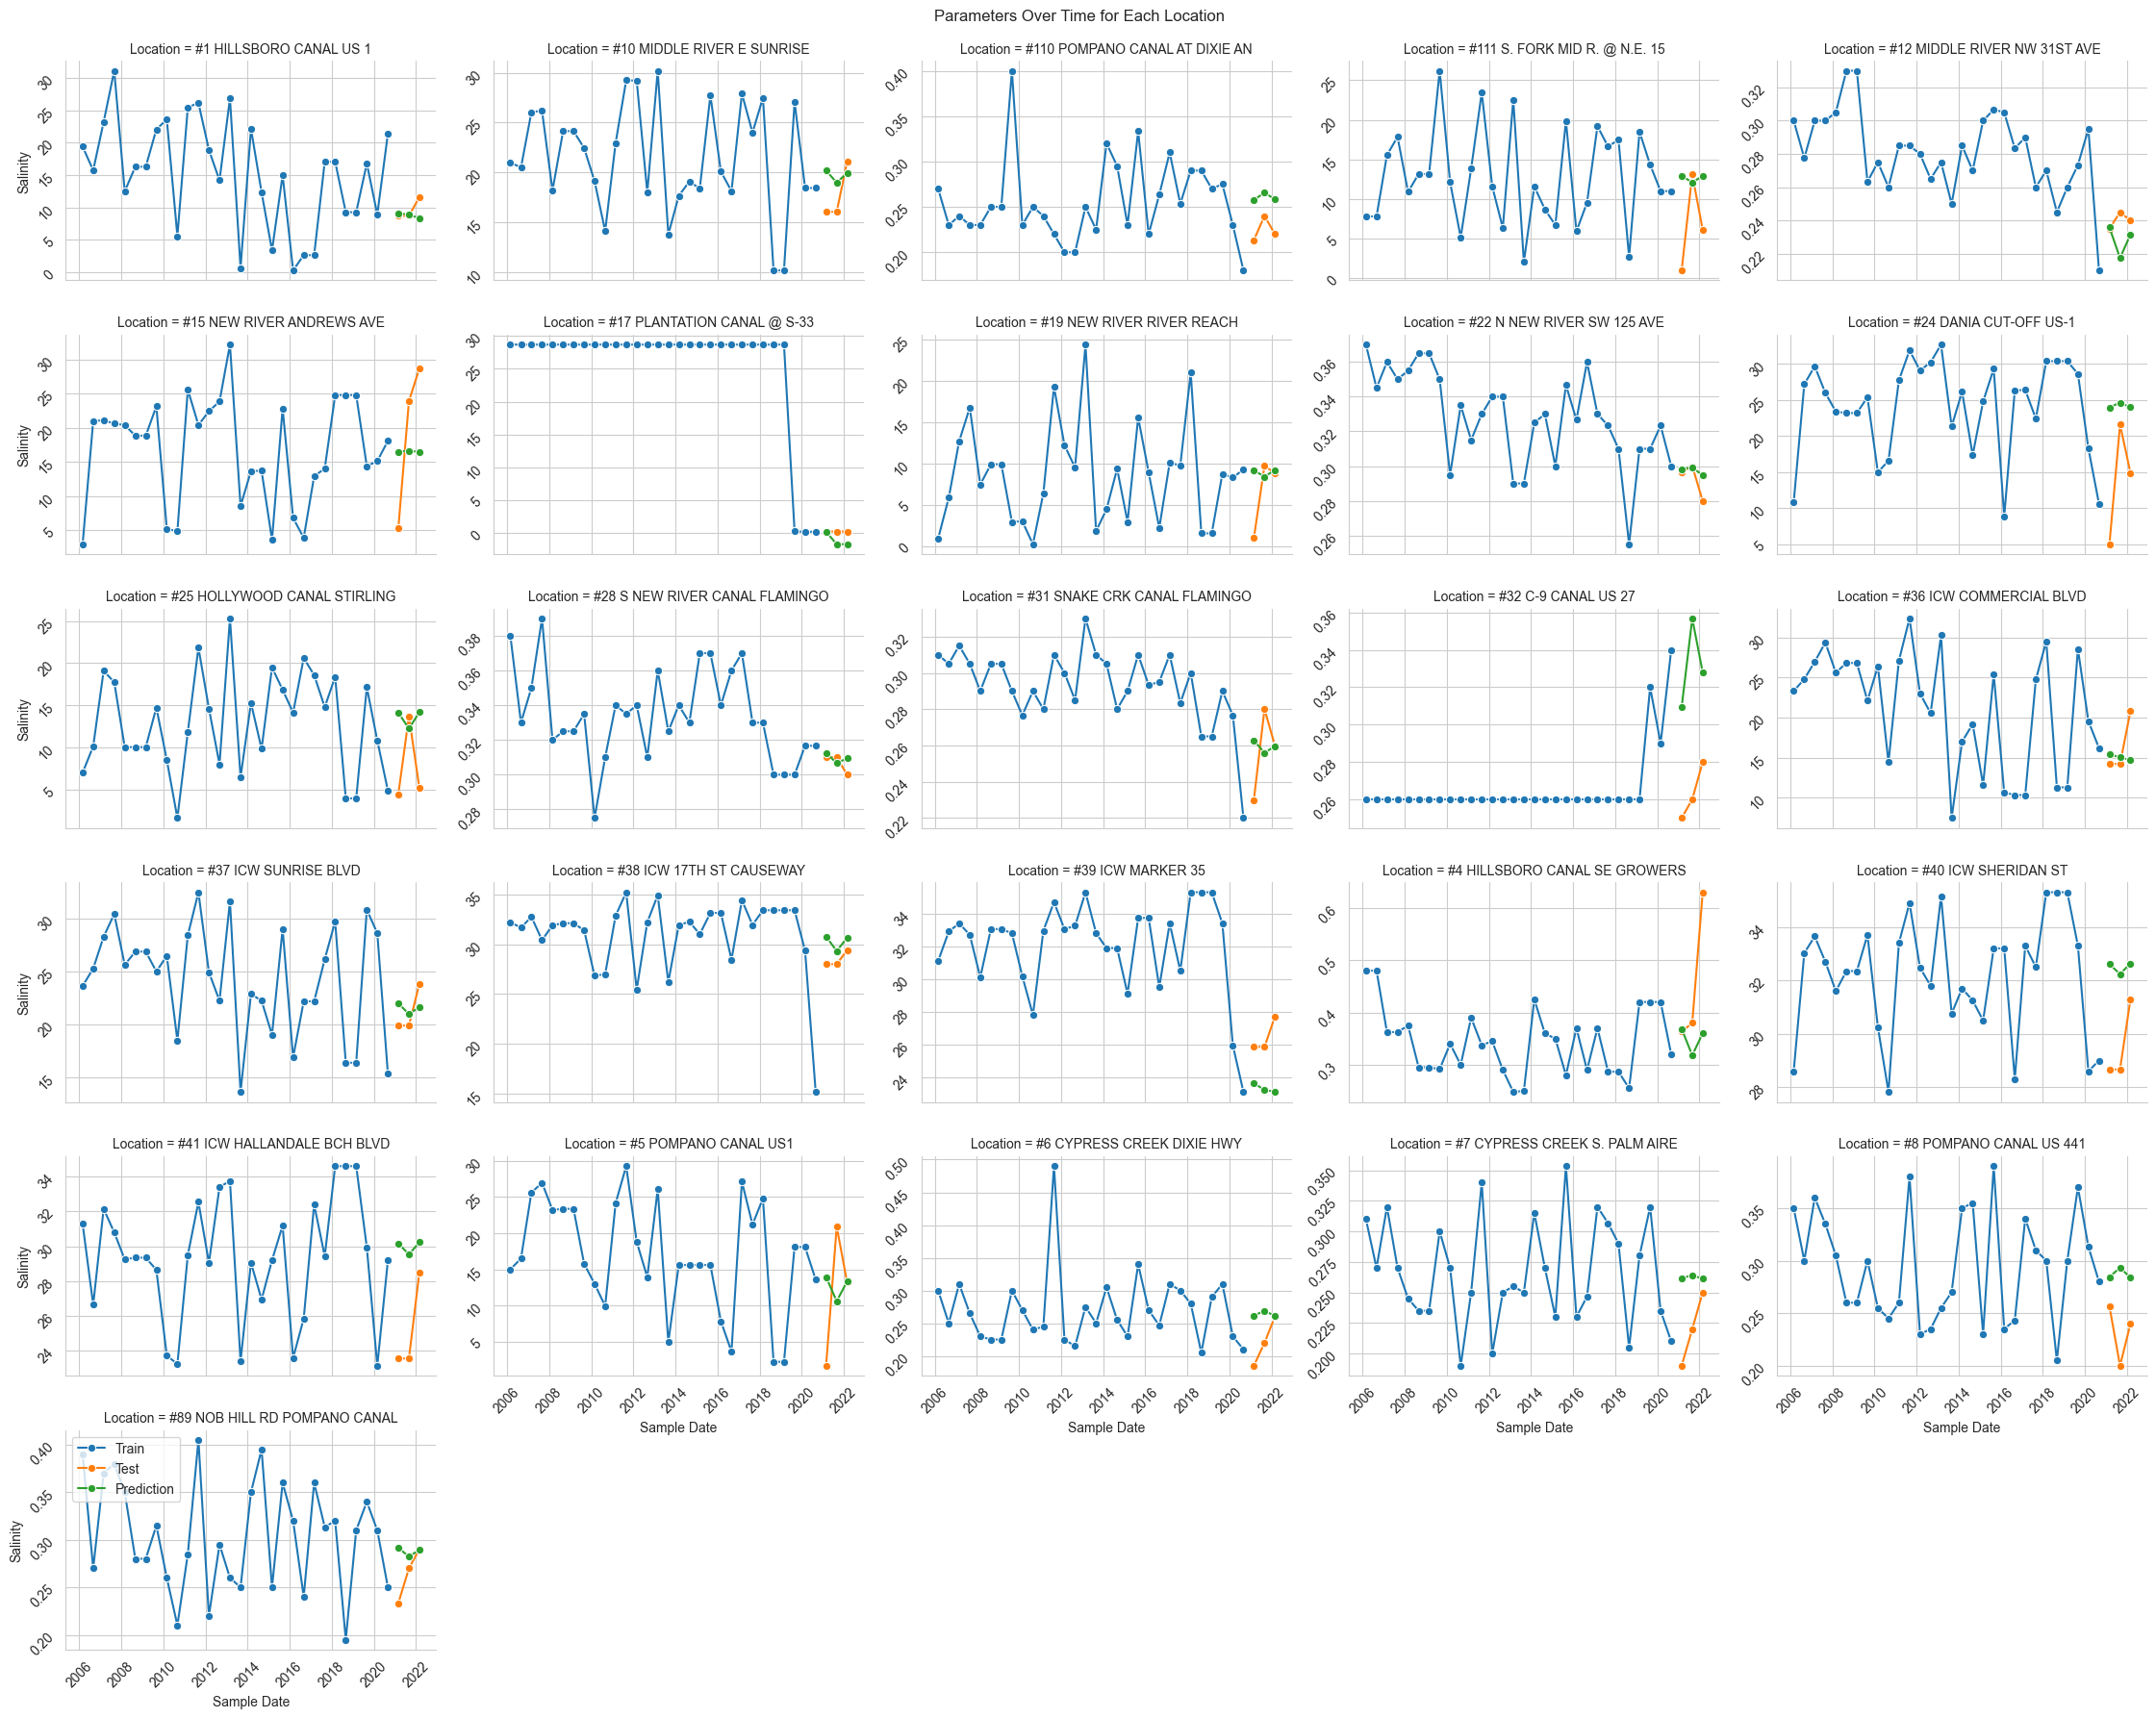

In [20]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Parameters Over Time for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [21]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [22]:
accuracy.sort_values(by="RMSE")

Location        MAE         MSE       RMSE
11  #28 S NEW RIVER CANAL FLAMINGO   0.005170    0.000036   0.006005
8       #22 N NEW RIVER SW 125 AVE   0.005655    0.000072   0.008513
4     #12 MIDDLE RIVER NW 31ST AVE   0.012272    0.000277   0.016647
12    #31 SNAKE CRK CANAL FLAMINGO   0.019105    0.000553   0.023513
25   #89 NOB HILL RD POMPANO CANAL   0.023756    0.001180   0.034355
2   #110 POMPANO CANAL AT DIXIE AN   0.036138    0.001369   0.036999
23   #7 CYPRESS CREEK S. PALM AIRE   0.042313    0.002401   0.049004
22      #6 CYPRESS CREEK DIXIE HWY   0.042278    0.002761   0.052546
24         #8 POMPANO CANAL US 441   0.055003    0.003805   0.061688
13             #32 C-9 CANAL US 27   0.068054    0.005067   0.071181
18   #4 HILLSBORO CANAL SE GROWERS   0.112383    0.025546   0.159830
6      #17 PLANTATION CANAL @ S-33   1.303425    2.492581   1.578791
15            #37 ICW SUNRISE BLVD   1.788636    3.449416   1.857260
0          #1 HILLSBORO CANAL US 1   1.275938    3.553904   1.885180
16        #38 ICW 17TH ST CAUSEWAY   1.776269    3.643365   1.908760
1       #10 MIDDLE RIVER E SUNRISE   2.733077    8.968336   2.994718
19             #40 ICW SHERIDAN ST   2.950242   10.027720   3.166658
17               #39 ICW MARKER 35   3.140120   10.928583   3.305841
14         #36 ICW COMMERCIAL BLVD   2.717040   13.137677   3.624593
7        #19 NEW RIVER RIVER REACH   3.304969   23.148150   4.811252
20     #41 ICW HALLANDALE BCH BLVD   4.766664   27.394597   5.233985
10    #25 HOLLYWOOD CANAL STIRLING   6.682638   58.458198   7.645796
3    #111 S. FORK MID R. @ N.E. 15   6.594139   63.471017   7.966870
21            #5 POMPANO CANAL US1   7.559271   85.291620   9.235346
5        #15 NEW RIVER ANDREWS AVE  10.234855  109.375226  10.458261
9           #24 DANIA CUT-OFF US-1  10.371627  150.691460  12.275645

## Specific Conductance

In [23]:
param = 'Specific Conductance'

In [24]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location].set_index("Sample Date")
    train_df.index = pd.to_datetime(train_df.index)  # Convert index to DateTimeIndex
    
    # Fit ETS model
    trend = 'additive'  # or 'multiplicative'
    seasonal_periods = 2  # Assuming monthly data
    model = ExponentialSmoothing(train_df[param], trend=trend, seasonal='add', seasonal_periods=seasonal_periods)
    result = model.fit()
    
    # Forecast future values
    forecast = result.forecast(steps=3)  # Forecasting next 3 periods into the future
    forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast
    
    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index, param: forecast_values}))

pred_data = pd.concat(predictions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_30097/2626036118.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_30097/2626036118.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-

In [25]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

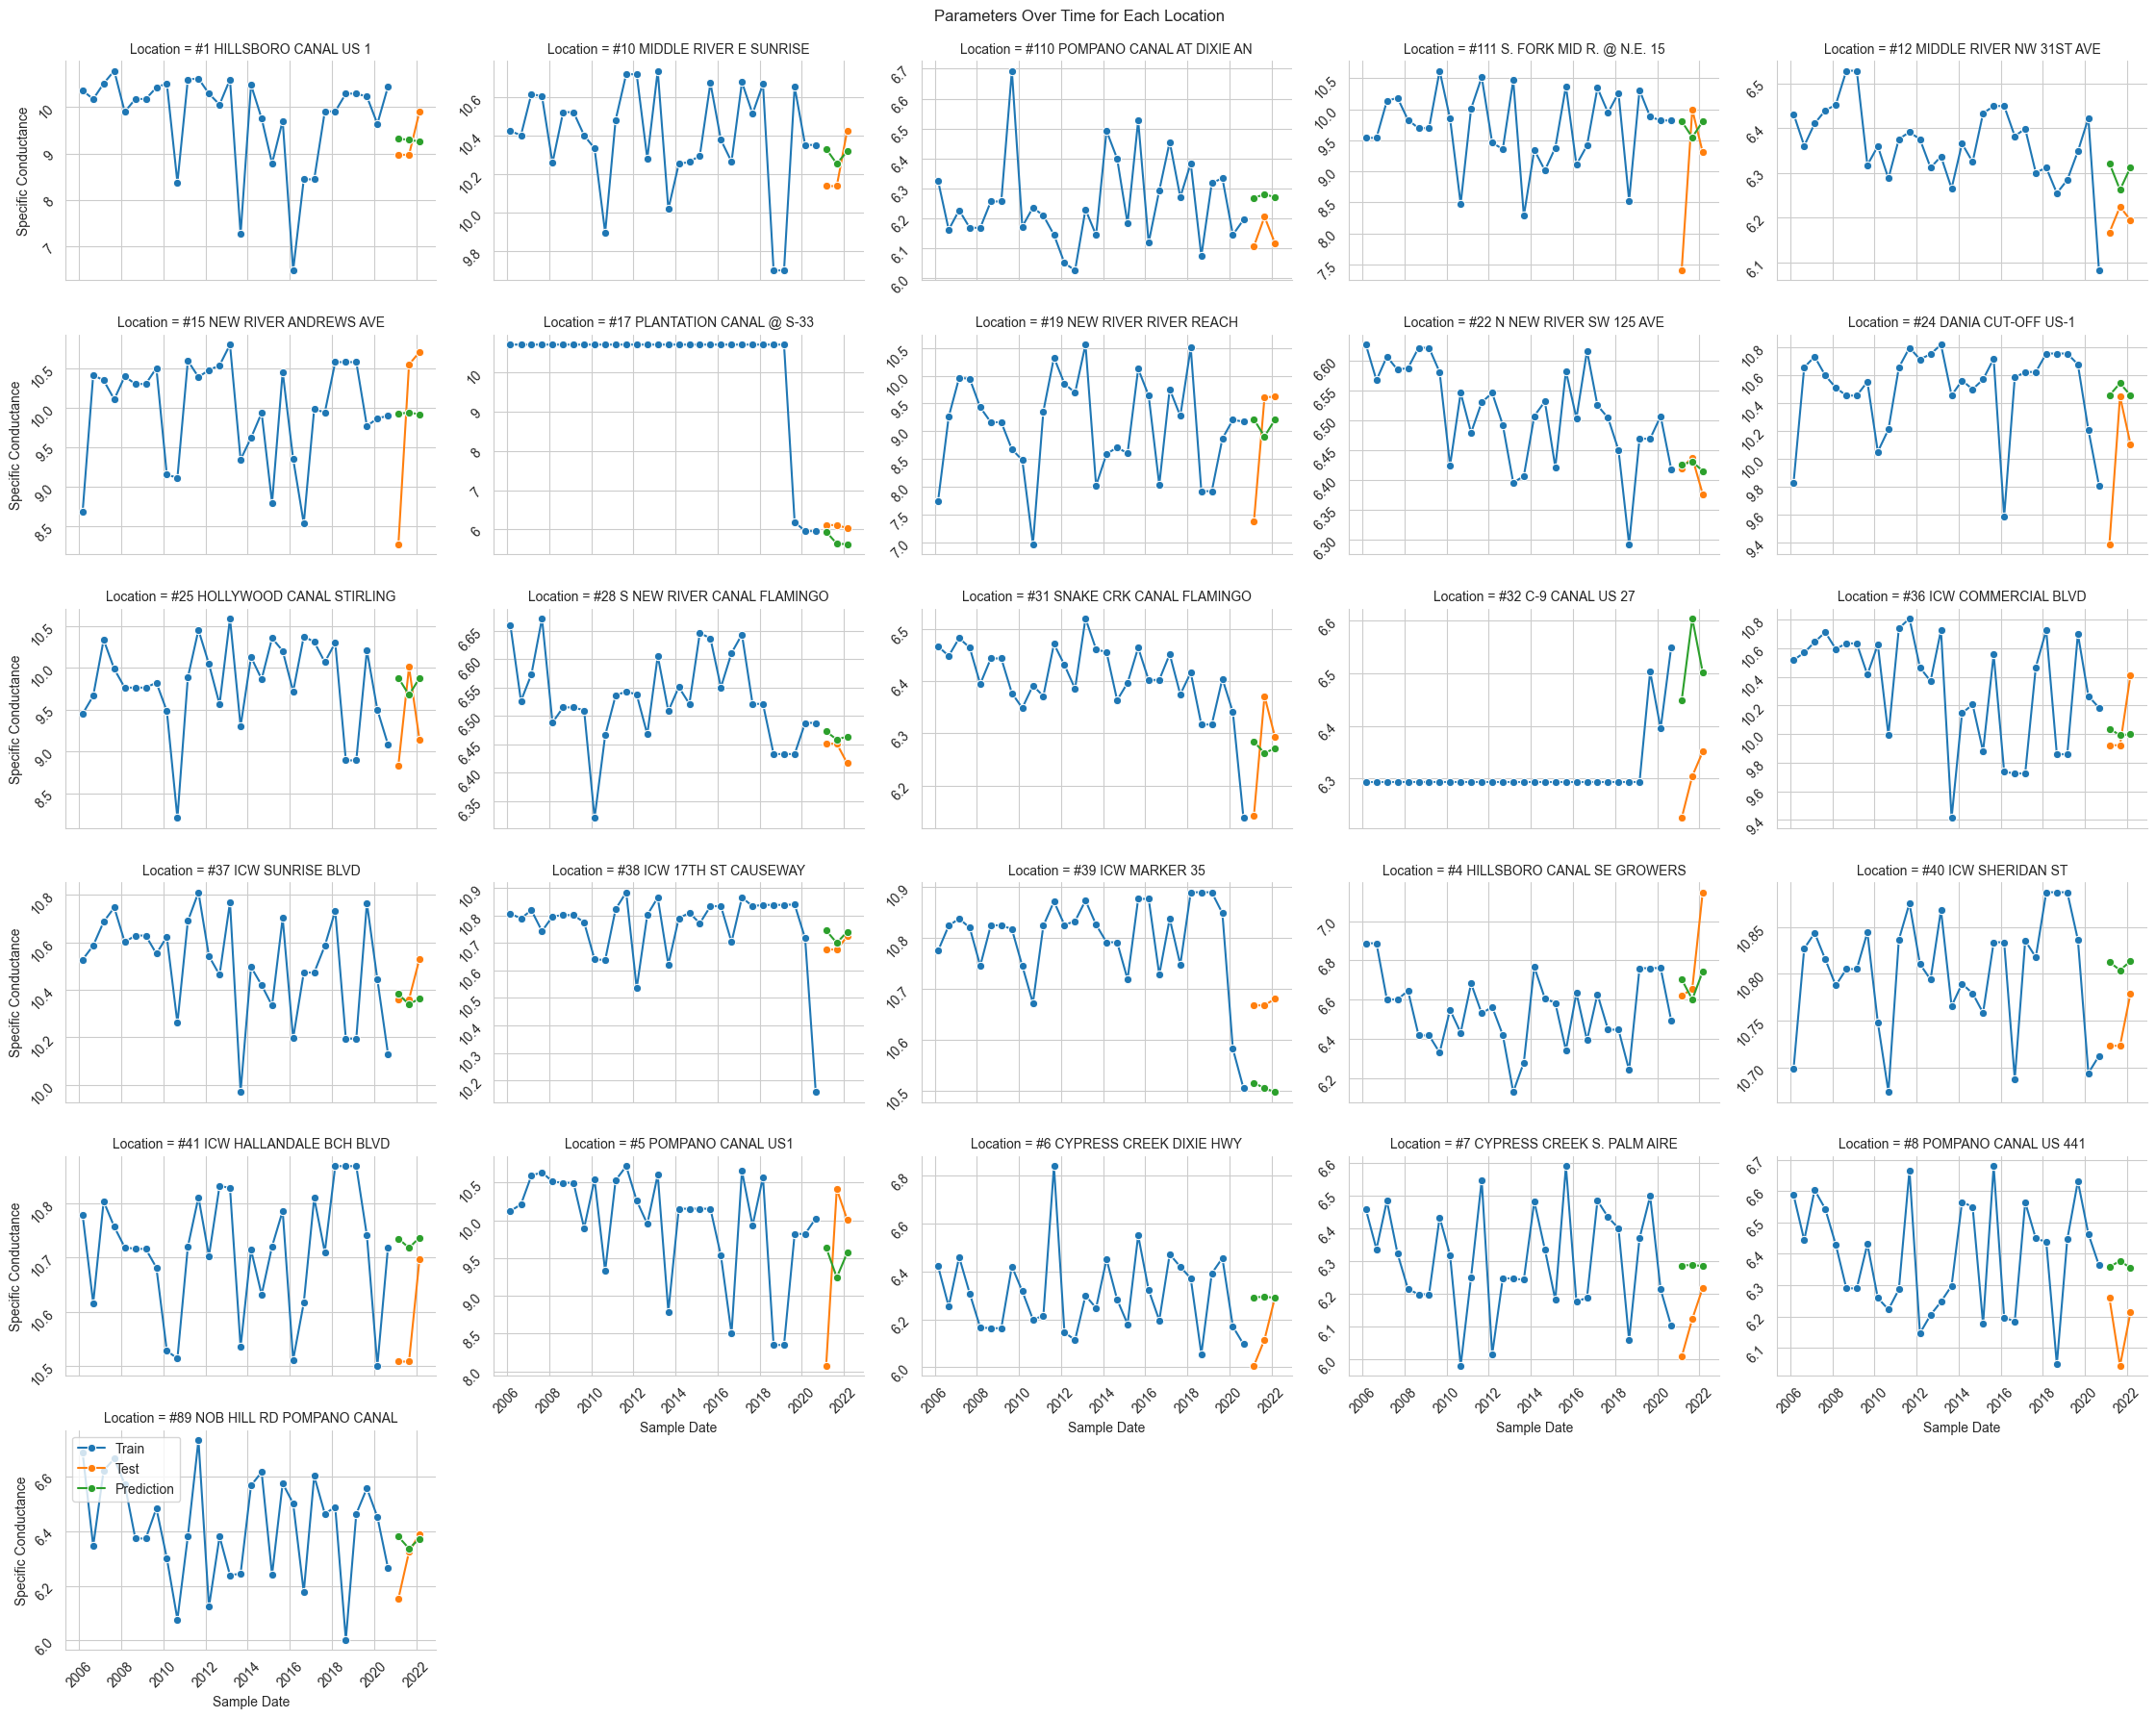

In [26]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Parameters Over Time for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [27]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [28]:
accuracy.sort_values(by="RMSE")

Location       MAE       MSE      RMSE
8       #22 N NEW RIVER SW 125 AVE  0.017141  0.000525  0.022915
11  #28 S NEW RIVER CANAL FLAMINGO  0.025310  0.000915  0.030241
16        #38 ICW 17TH ST CAUSEWAY  0.036743  0.001885  0.043414
19             #40 ICW SHERIDAN ST  0.068477  0.005271  0.072602
15            #37 ICW SUNRISE BLVD  0.069713  0.009485  0.097392
12    #31 SNAKE CRK CANAL FLAMINGO  0.090979  0.010855  0.104186
4     #12 MIDDLE RIVER NW 31ST AVE  0.103336  0.013076  0.114349
25   #89 NOB HILL RD POMPANO CANAL  0.084880  0.017217  0.131213
2   #110 POMPANO CANAL AT DIXIE AN  0.130396  0.018520  0.136088
1       #10 MIDDLE RIVER E SUNRISE  0.138928  0.020773  0.144129
17               #39 ICW MARKER 35  0.165726  0.027629  0.166220
20     #41 ICW HALLANDALE BCH BLVD  0.158895  0.032329  0.179803
23   #7 CYPRESS CREEK S. PALM AIRE  0.169705  0.036264  0.190430
22      #6 CYPRESS CREEK DIXIE HWY  0.155685  0.037927  0.194749
24         #8 POMPANO CANAL US 441  0.191733  0.047309  0.217507
13             #32 C-9 CANAL US 27  0.224320  0.053996  0.232371
18   #4 HILLSBORO CANAL SE GROWERS  0.181438  0.057842  0.240504
14         #36 ICW COMMERCIAL BLVD  0.199641  0.062885  0.250769
6      #17 PLANTATION CANAL @ S-33  0.350272  0.139599  0.373629
0          #1 HILLSBORO CANAL US 1  0.435168  0.209934  0.458186
9           #24 DANIA CUT-OFF US-1  0.502871  0.421936  0.649566
10    #25 HOLLYWOOD CANAL STIRLING  0.703127  0.578660  0.760697
5        #15 NEW RIVER ANDREWS AVE  1.013396  1.233445  1.110606
21            #5 POMPANO CANAL US1  1.057543  1.336381  1.156020
7        #19 NEW RIVER RIVER REACH  0.986388  1.352853  1.163122
3    #111 S. FORK MID R. @ N.E. 15  1.117177  2.077302  1.441285

## Total Nitrogen

In [29]:
param = 'Total Nitrogen'

In [30]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location].set_index("Sample Date")
    train_df.index = pd.to_datetime(train_df.index)  # Convert index to DateTimeIndex
    
    # Fit ETS model
    trend = 'additive'  # or 'multiplicative'
    seasonal_periods = 2  # Assuming monthly data
    model = ExponentialSmoothing(train_df[param], trend=trend, seasonal='add', seasonal_periods=seasonal_periods)
    result = model.fit()
    
    # Forecast future values
    forecast = result.forecast(steps=3)  # Forecasting next 3 periods into the future
    forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast
    
    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index, param: forecast_values}))

pred_data = pd.concat(predictions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_30097/2626036118.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_30097/2626036118.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-

In [31]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

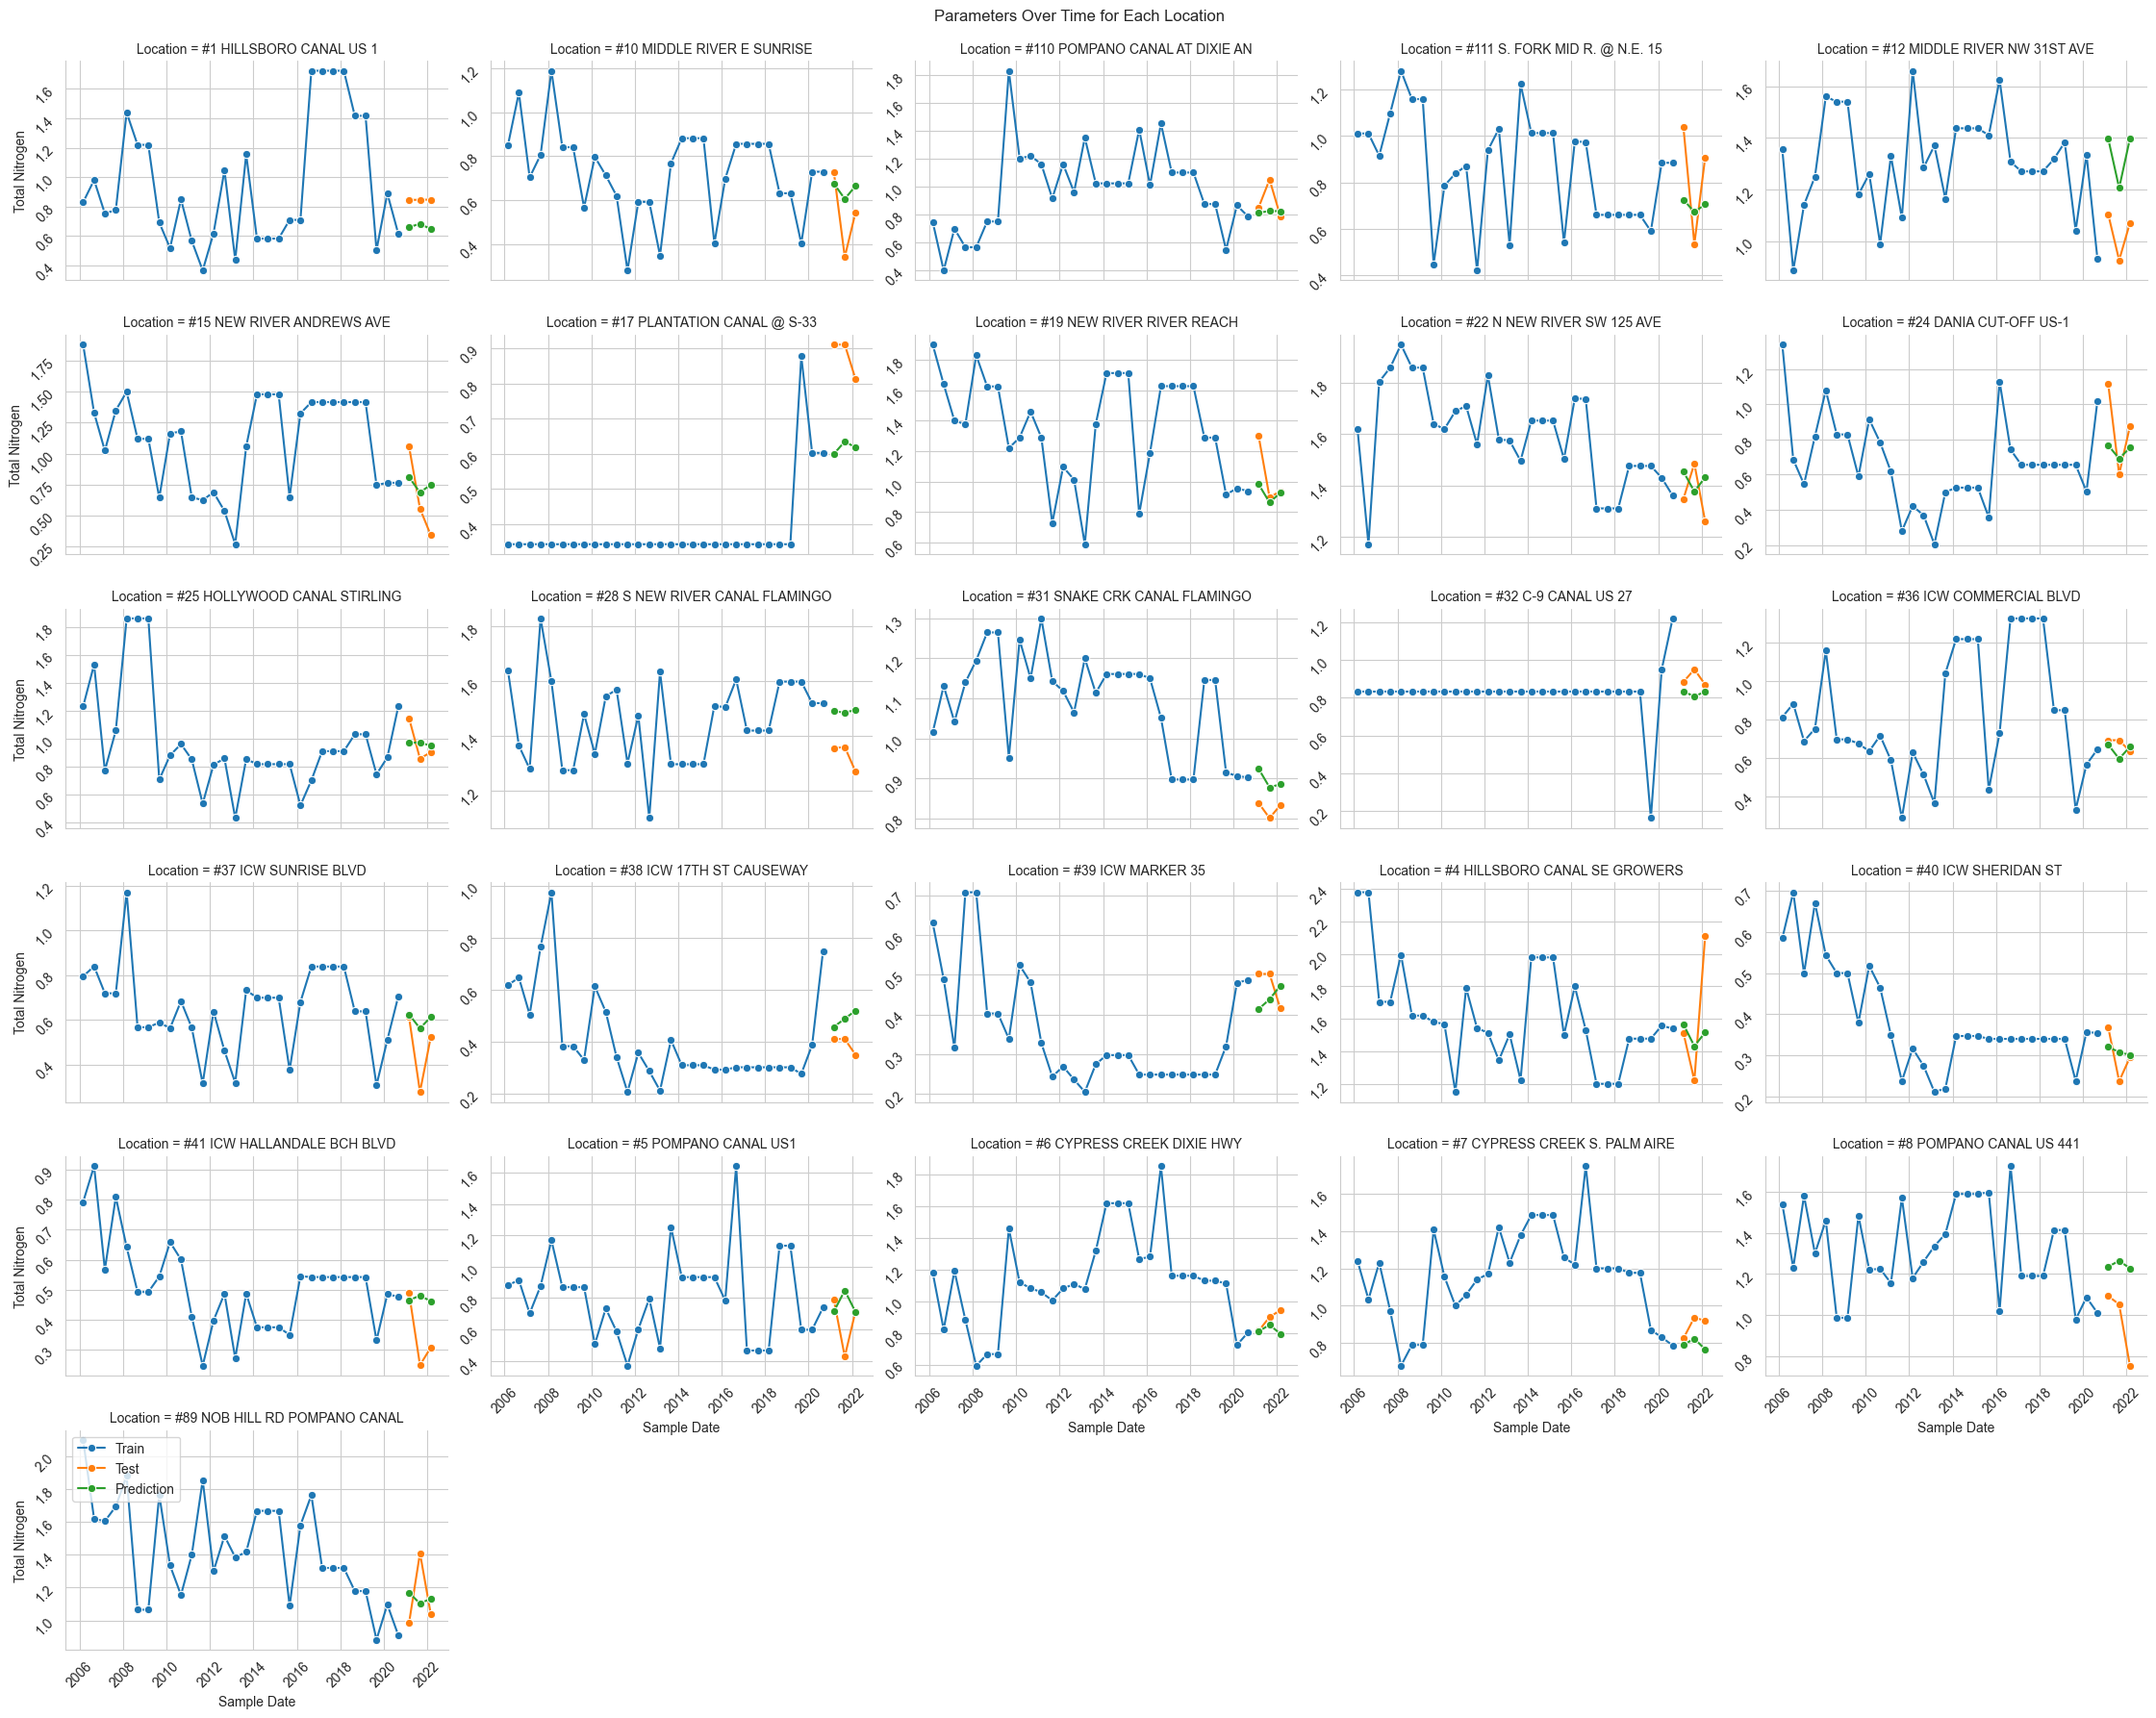

In [32]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Parameters Over Time for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [33]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [34]:
accuracy.sort_values(by="RMSE")

Location       MAE       MSE      RMSE
19             #40 ICW SHERIDAN ST  0.041564  0.002449  0.049487
14         #36 ICW COMMERCIAL BLVD  0.047840  0.003502  0.059179
17               #39 ICW MARKER 35  0.069877  0.005057  0.071116
12    #31 SNAKE CRK CANAL FLAMINGO  0.071594  0.005325  0.072976
22      #6 CYPRESS CREEK DIXIE HWY  0.067027  0.008175  0.090415
13             #32 C-9 CANAL US 27  0.076950  0.008186  0.090474
16        #38 ICW 17TH ST CAUSEWAY  0.098086  0.012347  0.111118
23   #7 CYPRESS CREEK S. PALM AIRE  0.100264  0.012450  0.111581
10    #25 HOLLYWOOD CANAL STIRLING  0.112742  0.015585  0.124840
8       #22 N NEW RIVER SW 125 AVE  0.129067  0.017548  0.132470
2   #110 POMPANO CANAL AT DIXIE AN  0.099651  0.017771  0.133307
20     #41 ICW HALLANDALE BCH BLVD  0.136748  0.026001  0.161248
11  #28 S NEW RIVER CANAL FLAMINGO  0.162771  0.028579  0.169053
1       #10 MIDDLE RIVER E SUNRISE  0.146034  0.029188  0.170844
15            #37 ICW SUNRISE BLVD  0.128640  0.029642  0.172169
0          #1 HILLSBORO CANAL US 1  0.182906  0.033700  0.183575
7        #19 NEW RIVER RIVER REACH  0.120202  0.033864  0.184021
25   #89 NOB HILL RD POMPANO CANAL  0.195577  0.045935  0.214325
9           #24 DANIA CUT-OFF US-1  0.186831  0.048442  0.220095
3    #111 S. FORK MID R. @ N.E. 15  0.216804  0.052202  0.228478
21            #5 POMPANO CANAL US1  0.168698  0.061608  0.248211
6      #17 PLANTATION CANAL @ S-33  0.260521  0.070253  0.265052
5        #15 NEW RIVER ANDREWS AVE  0.261819  0.081449  0.285393
4     #12 MIDDLE RIVER NW 31ST AVE  0.299972  0.090377  0.300628
24         #8 POMPANO CANAL US 441  0.276364  0.096751  0.311049
18   #4 HILLSBORO CANAL SE GROWERS  0.286065  0.133401  0.365241

## Total Phosphorus

In [35]:
param = 'Total Phosphorus'

In [36]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location].set_index("Sample Date")
    train_df.index = pd.to_datetime(train_df.index)  # Convert index to DateTimeIndex
    
    # Fit ETS model
    trend = 'additive'  # or 'multiplicative'
    seasonal_periods = 2  # Assuming monthly data
    model = ExponentialSmoothing(train_df[param], trend=trend, seasonal='add', seasonal_periods=seasonal_periods)
    result = model.fit()
    
    # Forecast future values
    forecast = result.forecast(steps=3)  # Forecasting next 3 periods into the future
    forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast
    
    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index, param: forecast_values}))

pred_data = pd.concat(predictions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_30097/2626036118.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_30097/2626036118.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-

In [37]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

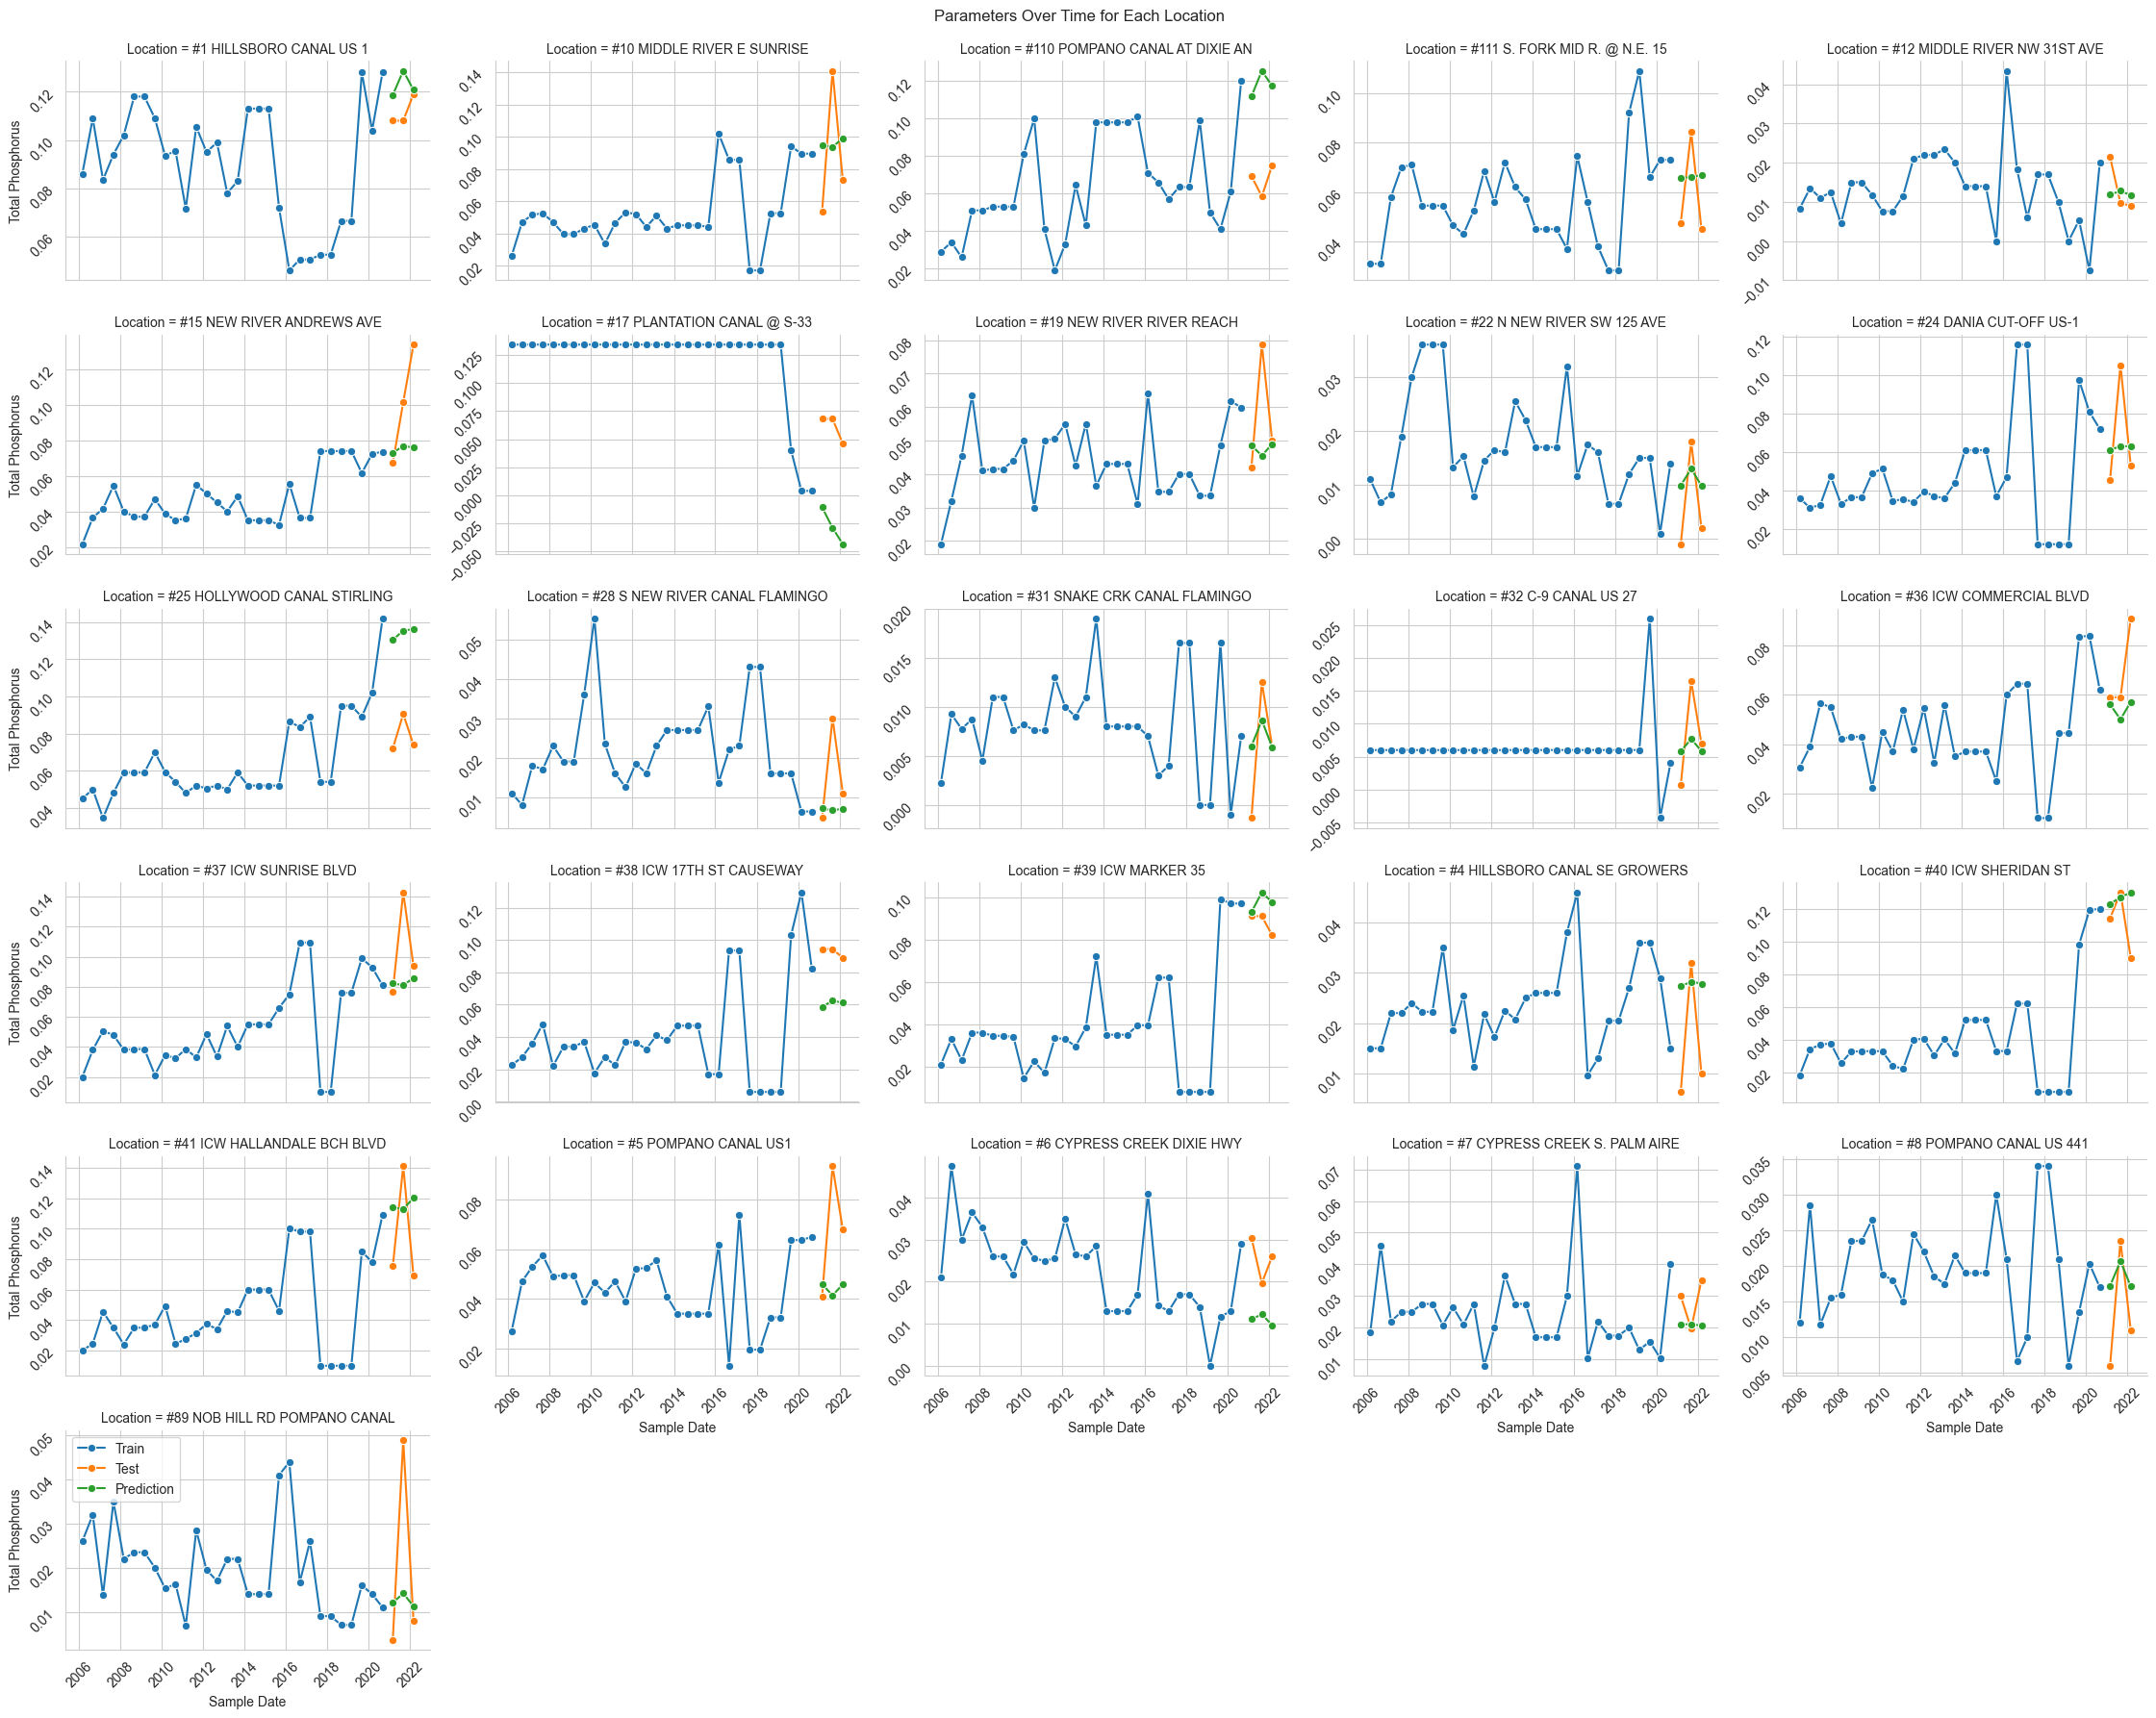

In [38]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Parameters Over Time for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [39]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [40]:
accuracy.sort_values(by="RMSE")

Location       MAE       MSE      RMSE
12    #31 SNAKE CRK CANAL FLAMINGO  0.003769  0.000023  0.004788
13             #32 C-9 CANAL US 27  0.005027  0.000035  0.005924
4     #12 MIDDLE RIVER NW 31ST AVE  0.005174  0.000037  0.006072
24         #8 POMPANO CANAL US 441  0.006723  0.000057  0.007554
8       #22 N NEW RIVER SW 125 AVE  0.007908  0.000068  0.008267
23   #7 CYPRESS CREEK S. PALM AIRE  0.008230  0.000096  0.009779
17               #39 ICW MARKER 35  0.009591  0.000125  0.011184
0          #1 HILLSBORO CANAL US 1  0.011024  0.000181  0.013467
11  #28 S NEW RIVER CANAL FLAMINGO  0.009939  0.000189  0.013765
22      #6 CYPRESS CREEK DIXIE HWY  0.014396  0.000233  0.015273
18   #4 HILLSBORO CANAL SE GROWERS  0.014206  0.000258  0.016060
7        #19 NEW RIVER RIVER REACH  0.013587  0.000382  0.019537
3    #111 S. FORK MID R. @ N.E. 15  0.019493  0.000383  0.019567
14         #36 ICW COMMERCIAL BLVD  0.015234  0.000412  0.020294
25   #89 NOB HILL RD POMPANO CANAL  0.015483  0.000431  0.020763
19             #40 ICW SHERIDAN ST  0.017240  0.000558  0.023632
9           #24 DANIA CUT-OFF US-1  0.022559  0.000707  0.026588
16        #38 ICW 17TH ST CAUSEWAY  0.031817  0.001023  0.031978
21            #5 POMPANO CANAL US1  0.026419  0.001078  0.032840
15            #37 ICW SUNRISE BLVD  0.025102  0.001310  0.036194
5        #15 NEW RIVER ANDREWS AVE  0.029432  0.001335  0.036540
1       #10 MIDDLE RIVER E SUNRISE  0.038055  0.001527  0.039079
20     #41 ICW HALLANDALE BCH BLVD  0.039303  0.001633  0.040412
2   #110 POMPANO CANAL AT DIXIE AN  0.050638  0.002699  0.051948
10    #25 HOLLYWOOD CANAL STIRLING  0.055207  0.003103  0.055701
6      #17 PLANTATION CANAL @ S-33  0.088279  0.007849  0.088593

## Turbidity

In [41]:
param = 'Turbidity'

In [42]:
predictions = []
for location in train_data["Location"].unique():
    train_df = train_data[train_data["Location"] == location].set_index("Sample Date")
    train_df.index = pd.to_datetime(train_df.index)  # Convert index to DateTimeIndex
    
    # Fit ETS model
    trend = 'additive'  # or 'multiplicative'
    seasonal_periods = 2  # Assuming monthly data
    model = ExponentialSmoothing(train_df[param], trend=trend, seasonal='add', seasonal_periods=seasonal_periods)
    result = model.fit()
    
    # Forecast future values
    forecast = result.forecast(steps=3)  # Forecasting next 3 periods into the future
    forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
    forecast_values = forecast
    
    predictions.append(pd.DataFrame({"Location": [location]*3, "Sample Date": forecast_index, param: forecast_values}))

pred_data = pd.concat(predictions)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_30097/2626036118.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-1], periods=4, freq='6M')[1:]
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 2QE-NOV will be used.
  self._init_dates(dates, freq)
/var/folders/9n/nyfs9h7n2lsfs0vd2lq0589h0000gn/T/ipykernel_30097/2626036118.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=train_df.index[-

In [43]:
# Concatenate train and test data for plotting
combined_data = pd.concat([train_data.assign(dataset='Train'), test_data.assign(dataset='Test'), pred_data.assign(dataset='Prediction')])

<Figure size 2000x1500 with 0 Axes>

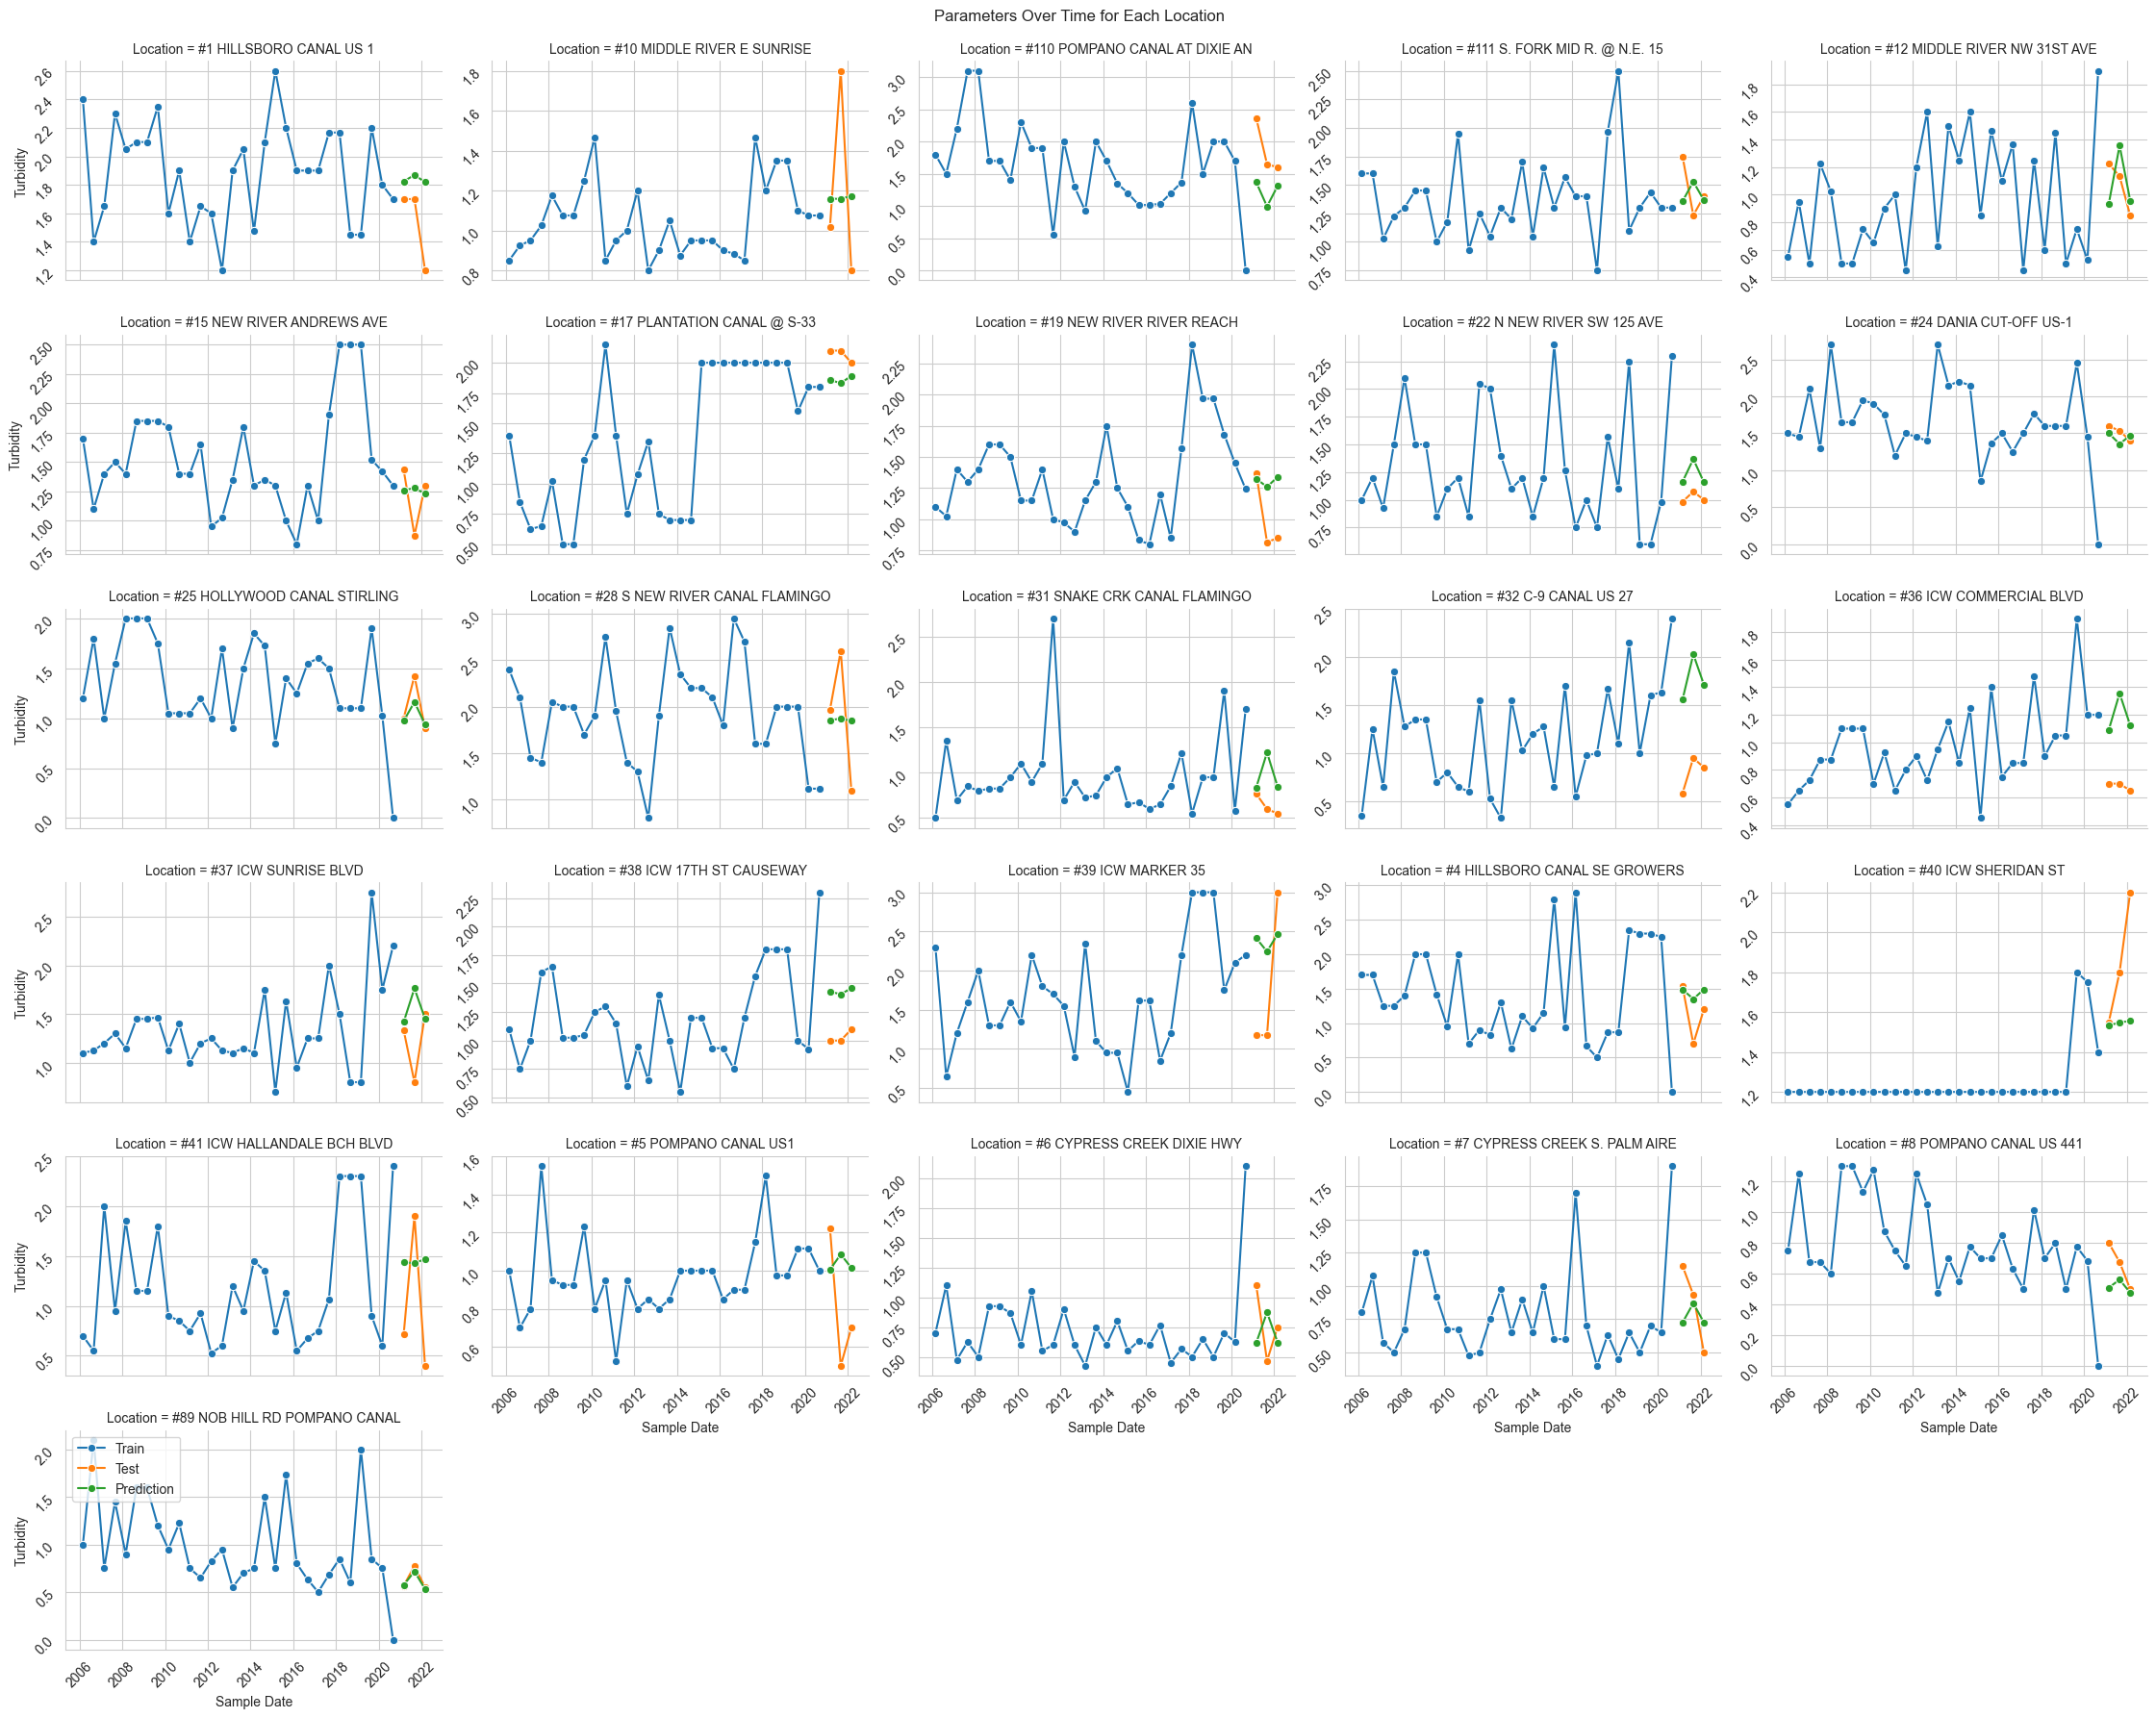

In [44]:
# Convert "Sample Date" to datetime
combined_data["Sample Date"] = pd.to_datetime(combined_data["Sample Date"])

# Create facet plot
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")
g = sns.FacetGrid(combined_data, col="Location", hue="dataset", col_wrap=5, height=3, aspect=1.5, sharey=False)

# Iterate over each parameter and map them onto the facet grid for both train and test data
line = g.map(sns.lineplot, "Sample Date", param, marker="o")

# Rotate x-axis labels for better readability
for ax in g.axes.ravel():
    ax.tick_params(labelrotation=45)

plt.subplots_adjust(top=0.95)
g.fig.suptitle('Parameters Over Time for Each Location')

# Adjust legend
plt.legend(loc='upper left')

plt.show()

In [45]:
maes, mses, rmses = [], [], []
for location in train_data["Location"].unique():
    test_df = test_data[test_data["Location"]==location]
    pred_df = pred_data[pred_data["Location"]==location]
    mae = mean_absolute_error(test_df[param], pred_df[param])
    mse = mean_squared_error(test_df[param], pred_df[param])
    rmse = np.sqrt(mse)

    maes.append(mae)
    mses.append(mse)
    rmses.append(rmse)
accuracy = pd.DataFrame({"Location": train_data["Location"].unique(),
              "MAE": maes,
              "MSE": mses,
              "RMSE": rmses,
            })

In [46]:
accuracy.sort_values(by="RMSE")

Location       MAE       MSE      RMSE
25   #89 NOB HILL RD POMPANO CANAL  0.027767  0.001228  0.035047
9           #24 DANIA CUT-OFF US-1  0.116412  0.015549  0.124696
10    #25 HOLLYWOOD CANAL STIRLING  0.108681  0.023534  0.153409
24         #8 POMPANO CANAL US 441  0.143011  0.032773  0.181032
6      #17 PLANTATION CANAL @ S-33  0.206109  0.047451  0.217832
8       #22 N NEW RIVER SW 125 AVE  0.210490  0.047798  0.218628
4     #12 MIDDLE RIVER NW 31ST AVE  0.207038  0.048586  0.220422
5        #15 NEW RIVER ANDREWS AVE  0.218061  0.067165  0.259163
23   #7 CYPRESS CREEK S. PALM AIRE  0.238051  0.078528  0.280228
3    #111 S. FORK MID R. @ N.E. 15  0.240896  0.080883  0.284399
22      #6 CYPRESS CREEK DIXIE HWY  0.339322  0.138188  0.371737
0          #1 HILLSBORO CANAL US 1  0.304251  0.142481  0.377466
7        #19 NEW RIVER RIVER REACH  0.324860  0.145943  0.382025
19             #40 ICW SHERIDAN ST  0.304777  0.159839  0.399799
16        #38 ICW 17TH ST CAUSEWAY  0.399158  0.160170  0.400212
12    #31 SNAKE CRK CANAL FLAMINGO  0.329920  0.160255  0.400319
21            #5 POMPANO CANAL US1  0.373571  0.163688  0.404584
18   #4 HILLSBORO CANAL SE GROWERS  0.328776  0.169745  0.412001
1       #10 MIDDLE RIVER E SUNRISE  0.385868  0.190553  0.436524
14         #36 ICW COMMERCIAL BLVD  0.507433  0.269637  0.519266
15            #37 ICW SUNRISE BLVD  0.366023  0.312685  0.559182
11  #28 S NEW RIVER CANAL FLAMINGO  0.529213  0.367278  0.606035
2   #110 POMPANO CANAL AT DIXIE AN  0.647742  0.503596  0.709645
20     #41 ICW HALLANDALE BCH BLVD  0.755063  0.630004  0.793728
13             #32 C-9 CANAL US 27  0.970935  0.950474  0.974922
17               #39 ICW MARKER 35  0.946704  0.986571  0.993263